# Homework 3

Before starting notebook, activate viz: *jupyter nbextension enable vega --py*

In [1]:
import pandas as pd
import numpy as np
import folium
import json
import os
import csv
%matplotlib inline

## Initial variables and helper functions

In [2]:
topo_path_json_eu = os.path.join('topojson', 'europe.topojson.json')
topo_path_json_ch = os.path.join('topojson', 'ch-cantons.topojson.json')

path_unemployment_eu_month = os.path.join('FetchedData', 'UnemploymentEUMonth', "une_rt_m.tsv")

color_undef = "#000000"

# picked with colorbrewer, orange since unemployment rate is bad
color_classes = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']

## Our definition of unemployment rate

Seasonal ajusted, only registered unemployed, both genders, quaterly

## Unemployment rate in Europe at a country level

15 - 74

In [3]:
map_europe = folium.Map([57,18], zoom_start=3)
map_europe

### Preprocess downloaded data

In [4]:
df_unemployment_eu_month = pd.read_csv(path_unemployment_eu_month, sep='\t')
df_unemployment_eu_month.head()

,"s_adj,age,unit,sex,geo\time",2017M09,2017M08,2017M07,2017M06,2017M05,2017M04,2017M03,2017M02,2017M01,...,1983M10,1983M09,1983M08,1983M07,1983M06,1983M05,1983M04,1983M03,1983M02,1983M01
0,"NSA,TOTAL,PC_ACT,F,AT",5.1,5.2,4.4,4.9,5.1,4.7,5.4,4.9,5.3,...,:,:,:,:,:,:,:,:,:,:
1,"NSA,TOTAL,PC_ACT,F,BE",7.2,7.7,7.6,6.8,6.9,7.4,8.0,8.2,7.8 b,...,:,:,:,:,:,:,:,:,:,:
2,"NSA,TOTAL,PC_ACT,F,BG",5.3,5.3,5.3,5.3,5.6,6.2,6.8,7.1,7.0,...,:,:,:,:,:,:,:,:,:,:
3,"NSA,TOTAL,PC_ACT,F,CY",10.7,12.2,12.4,11.4,10.7,11.4,13.1,13.9,14.0,...,:,:,:,:,:,:,:,:,:,:
4,"NSA,TOTAL,PC_ACT,F,CZ",3.5,3.5,3.4,3.5,3.5,4.2,4.4,4.3,4.2,...,:,:,:,:,:,:,:,:,:,:


In [5]:
# Filter colums: Only use latest month
cols_drop = [i for i in range(2,len(df_unemployment_eu_month.columns))]
df_unemployment_eu_month_clean = df_unemployment_eu_month.drop(df_unemployment_eu_month.columns[cols_drop], axis=1)
df_unemployment_eu_month_clean.head()

,"s_adj,age,unit,sex,geo\time",2017M09
0,"NSA,TOTAL,PC_ACT,F,AT",5.1
1,"NSA,TOTAL,PC_ACT,F,BE",7.2
2,"NSA,TOTAL,PC_ACT,F,BG",5.3
3,"NSA,TOTAL,PC_ACT,F,CY",10.7
4,"NSA,TOTAL,PC_ACT,F,CZ",3.5


In [6]:
# Filter rows
"""
SA := seasonal adjusted
TOTAL := all ages
PC_ACT := per capita
T := male and female
"""
unempl_filter = "SA,TOTAL,PC_ACT,T,"
df_unemployment_eu_month_clean = df_unemployment_eu_month_clean[df_unemployment_eu_month_clean.iloc[:,0].str.startswith(unempl_filter)]
df_unemployment_eu_month_clean.head()

,"s_adj,age,unit,sex,geo\time",2017M09
766,"SA,TOTAL,PC_ACT,T,AT",5.6
767,"SA,TOTAL,PC_ACT,T,BE",7.1
768,"SA,TOTAL,PC_ACT,T,BG",6.1
769,"SA,TOTAL,PC_ACT,T,CY",10.3
770,"SA,TOTAL,PC_ACT,T,CZ",2.7


In [7]:
# Filter counrty id
df_unemployment_eu_month_clean.iloc[:,0] = df_unemployment_eu_month_clean.iloc[:,0].apply(
    lambda x : x[len(unempl_filter):])
df_unemployment_eu_month_clean.head()

,"s_adj,age,unit,sex,geo\time",2017M09
766,AT,5.6
767,BE,7.1
768,BG,6.1
769,CY,10.3
770,CZ,2.7


In [8]:
# Replace unkown values, denoted by :
df_unemployment_eu_month_clean.iloc[:,1] = df_unemployment_eu_month_clean.iloc[:,1].apply(
    lambda x : -1 if ":" in x else x)
df_unemployment_eu_month_clean.head()

,"s_adj,age,unit,sex,geo\time",2017M09
766,AT,5.6
767,BE,7.1
768,BG,6.1
769,CY,10.3
770,CZ,2.7


In [9]:
# convert unemployment to float
df_unemployment_eu_month_clean.iloc[:,1] = pd.to_numeric(df_unemployment_eu_month_clean.iloc[:,1], errors='coerce')
df_unemployment_eu_month_clean.head()

,"s_adj,age,unit,sex,geo\time",2017M09
766,AT,5.6
767,BE,7.1
768,BG,6.1
769,CY,10.3
770,CZ,2.7


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000150935993C8>]], dtype=object)

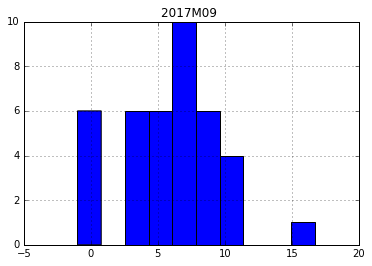

In [10]:
df_unemployment_eu_month_clean.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015093C477B8>]], dtype=object)

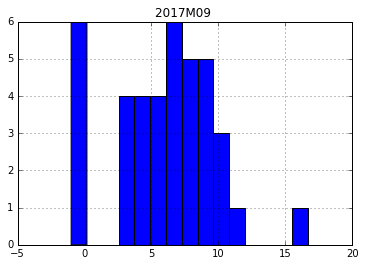

In [11]:
df_unemployment_eu_month_clean.hist(bins=15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001509411A080>]], dtype=object)

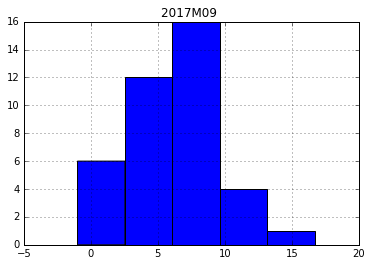

In [12]:
df_unemployment_eu_month_clean.hist(bins=5)

In [13]:
df_unemployment_eu_month_clean.sort_values(by=df_unemployment_eu_month_clean.columns[1], ascending=False).head()

,"s_adj,age,unit,sex,geo\time",2017M09
778,ES,16.7
788,IT,11.1
784,HR,10.5
769,CY,10.3
783,FR,9.7


In [14]:
def eu_get_umepmloyment_rate(country_id):
    col_bool_match = df_unemployment_eu_month_clean.iloc[:,0] == country_id
    if not col_bool_match.any():
        return -1
    else:
        row = df_unemployment_eu_month_clean.loc[col_bool_match]
        return row[row.columns[1]].values[0]

In [15]:
# calculate bin for unemployment
count, division = np.histogram(df_unemployment_eu_month_clean.iloc[:,1], bins=5)
def eu_get_class(unempl_rate):
    if unempl_rate < division[1]:
        return 0
    elif unempl_rate < division[2]:
        return 1
    elif unempl_rate < division[3]:
        return 2
    elif unempl_rate < division[4]:
        return 3
    else:
        return 4

In [16]:
def eu_class_color(class_id):
    return color_classes[class_id]

In [17]:
def eu_unemployment_colors(country_id):
    """Returns the color based on the unemployment rate for the given country"""
    unempl_rate = eu_get_umepmloyment_rate(country_id)
    if unempl_rate == -1:
        return color_undef
    else:
        class_id = eu_get_class(unempl_rate)
        return eu_class_color(class_id)

In [18]:
with open(topo_path_json_eu) as f:
    folium.TopoJson(
        f,
        "objects.europe",
        style_function=lambda country: {
            'fillColor': eu_unemployment_colors(country['id']),
            'color' : 'black',
            'weight' : 1,
            'dashArray' : '0, 0'
            }
        ).add_to(map_europe)
map_europe

In [ ]:
# TODO: Discuss data, change colors, add interactions

## Unemployment rate in Switzerland at a canton level

15+

In [ ]:
#state_geo = os.path.join('data', 'us-states.json')

#state_unemployment = os.path.join('data', 'US_Unemployment_Oct2012.csv')
#state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

m.choropleth(
    geo_data="",
    name='choropleth',
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
)

m